In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp

from dotenv import load_dotenv
load_dotenv(override=True)

ROOT_PATH = os.environ.get('ROOT_PATH')
if not ROOT_PATH in sys.path: sys.path.append(ROOT_PATH)

from main_code.utils.constants import *
from main_code.utils.CosmoFunc import *
from main_code.utils.logging_config import get_logger
from main_code.utils.filepaths import (
    LOGDIST_OUTPUT_FILEPATH
)
from main_code.step_12_smoothed_field import combine_my_logdist, generate_grids, get_supergalactic_coords, get_smoothing_length

from astropy import units as u
from astropy.coordinates import SkyCoord

SMIN_SETTING = int(os.environ.get('SMIN_SETTING'))
FP_FIT_METHOD = int(os.environ.get('FP_FIT_METHOD'))

# Top 10 cluster (by richness) from T17

In [90]:
# Load T17
df = pd.read_csv("../../data/external/tempel_group_sdss12/individual.txt", delim_whitespace='\t')
df = df.sort_values(by='Ngal', ascending=False)

df['pair'] = list(zip(df['GroupID'], df['Ngal']))
list(df['pair'].unique())

[(1537, 254),
 (1539, 223),
 (81, 188),
 (19278, 187),
 (421, 180),
 (2416, 148),
 (3053, 119),
 (292, 115),
 (8062, 107),
 (3978, 107),
 (1398, 106),
 (6372, 106),
 (185, 105),
 (6744, 104),
 (697, 104),
 (5596, 103),
 (424, 101),
 (2424, 98),
 (6333, 98),
 (2073, 96),
 (11455, 95),
 (937, 94),
 (2411, 93),
 (19280, 90),
 (460, 89),
 (522, 89),
 (19279, 88),
 (2423, 86),
 (6327, 86),
 (17458, 85),
 (12171, 85),
 (425, 85),
 (5567, 85),
 (1949, 85),
 (15574, 84),
 (422, 83),
 (526, 82),
 (2723, 81),
 (5183, 80),
 (2738, 79),
 (2496, 79),
 (5905, 78),
 (468, 78),
 (210, 77),
 (262, 76),
 (1042, 76),
 (5159, 75),
 (161, 74),
 (8050, 74),
 (1576, 74),
 (571, 73),
 (205, 73),
 (672, 72),
 (2425, 71),
 (885, 70),
 (2074, 70),
 (10827, 69),
 (1219, 68),
 (8887, 68),
 (351, 68),
 (967, 67),
 (2672, 67),
 (9917, 66),
 (11320, 65),
 (7498, 65),
 (2420, 64),
 (10842, 64),
 (7289, 63),
 (6376, 62),
 (499, 62),
 (352, 61),
 (2814, 61),
 (1429, 61),
 (4239, 59),
 (6334, 59),
 (2412, 59),
 (1963, 59

In [154]:
# Load T17
df = pd.read_csv("../../data/external/tempel_group_sdss12/group.txt", delim_whitespace='\t')
df = df[df['zcl'] < ZMAX]
df = df.sort_values(by='Ngal', ascending=False)

df = get_supergalactic_coords(df, ra_col_name='RAJ2000', dec_col_name='DEJ2000', z_dist_est_col_name='zcl')

df.head(10)

,GroupID,Ngal,RAJ2000,DEJ2000,zcl,SGLON,SGLAT,dz_dist_est,SGX,SGY,SGZ
1536,1537,254,194.182652,27.515600,0.024657,89.910697,7.554547,73.490727,0.113550,72.852750,9.661827
1538,1539,223,194.888428,27.937480,0.024410,89.645497,8.261142,72.758122,0.445498,72.001766,10.454256
19277,19278,187,187.458165,12.660248,0.005129,102.553059,-2.502369,15.357218,-3.334611,14.975812,-0.670507
420,421,180,246.942018,39.401823,0.031119,72.679657,50.120283,92.608180,17.677751,56.685828,71.066793
2415,2416,148,240.570631,15.814910,0.035707,110.175202,48.516736,106.146934,-24.249997,65.997693,79.519895
3977,3978,107,230.780554,8.588612,0.035168,117.716833,37.852078,104.558480,-38.398426,73.086045,64.159697
8061,8062,107,173.738631,49.090739,0.033746,64.427524,-0.638945,100.362945,43.319219,90.525760,-1.119193
1397,1398,106,228.111623,7.422346,0.045812,118.350722,35.008672,135.856592,-52.841074,97.928738,77.940983
6371,6372,106,220.202988,3.471932,0.027716,120.423559,26.383243,82.547821,-37.447311,63.767308,36.682039
696,697,104,234.921764,21.728090,0.041752,101.188083,43.542208,123.936590,-17.431209,88.130240,85.378522


In [4]:
LIGHTSPEED * 0.024410 / 70.5

103.80048084794326

Cluster identifications:
1. 1537: NGC 4839 Group | Next to Coma cluster (merging)
2. 1539: Coma cluster | Coma Berenices
3. 19278: Virgo cluster? | Virgo
4. 421: Abell 2199 | Hercules
5. 2416: Abell 2147 (Core of Hercules superclusters)
6. 3978: MKW 3? | 
7. 8062: Abell 1314 | Ursa Major
8. 1398: Abell 2040 | Serpens/Corona Borealis
9. 6372: MKW 8 | Virgo
10. 697 | Hercules supercluster

In [2]:
# Load T17 individual
df = pd.read_csv("../../data/external/tempel_group_sdss12/individual.txt", delim_whitespace='\t')

df[df['GroupID'] == 1539]

,GalID,objID,GroupID,Ngal,RAJ2000,DEJ2000
14289,1320,1237667444048723983,1539,223,195.033862,27.976941
14290,3471,1237667444048658532,1539,223,194.898771,27.959263
14291,31916,1237667444048789588,1539,223,195.233589,27.790852
14292,39586,1237667444585594903,1539,223,195.074697,28.202398
14293,98246,1237667324334506008,1539,223,194.766250,28.123698
...,...,...,...,...,...,...
14507,580857,1237667444048658763,1539,223,194.882884,27.861297
14508,580983,1237667324334637213,1539,223,195.128979,28.108394
14509,581082,1237667444048527531,1539,223,194.548548,27.893662
14510,581089,1237667444048527579,1539,223,194.592827,27.884778


# NGC 4839 group (merging with Coma cluster)

Median redshift (SDSS): 0.02468
Median redshift (LAMOST): 0.02468
Median redshift (H22): 0.02468
Brightest member objid: 1237667443511590952


Text(0, 0.5, 'Dec')

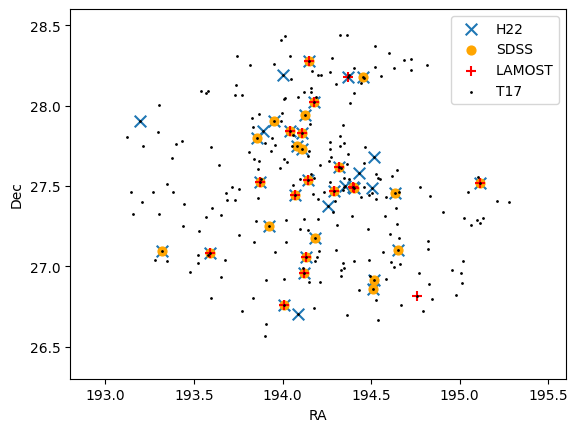

In [122]:
cluster_id = 1537

# Load tempel et al
df_full = pd.read_csv("../../data/external/tempel_group_sdss12/individual.txt", delim_whitespace='\t')
df_full = df_full[df_full['GroupID'] == cluster_id]

# Load SDSS
df_sdss = pd.read_csv("../../data/foundation/logdist/smin_setting_1/fp_fit_method_0/sdss.csv")
df_sdss = df_sdss[df_sdss['Group'] == cluster_id]
print(f"Median redshift (SDSS): {df_sdss['z_dist_est'].median()}")

# Load LAMOST
df_lamost = pd.read_csv("../../data/foundation/logdist/smin_setting_1/fp_fit_method_0/lamost.csv")
df_lamost = df_lamost[df_lamost['Group'] == cluster_id]
print(f"Median redshift (LAMOST): {df_lamost['z_dist_est'].median()}")

# Load H22
df_h22 = pd.read_csv("../../data/external/h22/cullan_logdist.csv")
df_h22 = df_h22[df_h22['IDgroupT17'] == cluster_id]
brightest_member = df_h22.sort_values(by='deVMag_r')['objid'].tolist()[0]
print(f"Median redshift (H22): {df_h22['zcmb_group'].median()}")
print(f"Brightest member objid: {brightest_member}")


plt.scatter(df_h22['RA'], df_h22['Dec'], marker='x', s=70, label='H22')

plt.scatter(df_sdss['ra'], df_sdss['dec'], s=40, c='orange', marker='o', facecolors='none', label='SDSS')
plt.scatter(df_lamost['ra'], df_lamost['dec'], s=50, c='r', marker='+', label='LAMOST')

plt.scatter(df_full['RAJ2000'], df_full['DEJ2000'], s=1, c='k', label='T17')

# plt.grid()
plt.legend()
plt.xlim(192.8, 195.6)
plt.ylim(26.3, 28.6)
plt.xlabel('RA')
plt.ylabel('Dec')


# Coma cluster

Median redshift (SDSS): 0.02444
Median redshift (LAMOST): 0.02444
Median redshift (H22): 0.02444
Brightest member objid: 1237667444048723983


Text(0, 0.5, 'Dec')

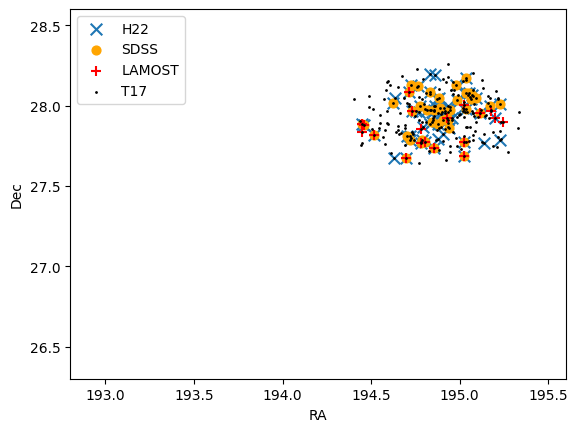

In [121]:
cluster_id = 1539

# Load tempel et al
df_full = pd.read_csv("../../data/external/tempel_group_sdss12/individual.txt", delim_whitespace='\t')
df_full = df_full[df_full['GroupID'] == cluster_id]

# Load SDSS
df_sdss = pd.read_csv("../../data/foundation/logdist/smin_setting_1/fp_fit_method_0/sdss.csv")
df_sdss = df_sdss[df_sdss['Group'] == cluster_id]
print(f"Median redshift (SDSS): {df_sdss['z_dist_est'].median()}")

# Load LAMOST
df_lamost = pd.read_csv("../../data/foundation/logdist/smin_setting_1/fp_fit_method_0/lamost.csv")
df_lamost = df_lamost[df_lamost['Group'] == cluster_id]
print(f"Median redshift (LAMOST): {df_lamost['z_dist_est'].median()}")

# Load H22
df_h22 = pd.read_csv("../../data/external/h22/cullan_logdist.csv")
df_h22 = df_h22[df_h22['IDgroupT17'] == cluster_id]
brightest_member = df_h22.sort_values(by='deVMag_r')['objid'].tolist()[0]
print(f"Median redshift (H22): {df_h22['zcmb_group'].median()}")
print(f"Brightest member objid: {brightest_member}")


plt.scatter(df_h22['RA'], df_h22['Dec'], marker='x', s=70, label='H22')

plt.scatter(df_sdss['ra'], df_sdss['dec'], s=40, c='orange', marker='o', facecolors='none', label='SDSS')
plt.scatter(df_lamost['ra'], df_lamost['dec'], s=50, c='r', marker='+', label='LAMOST')

plt.scatter(df_full['RAJ2000'], df_full['DEJ2000'], s=1, c='k', label='T17')

# plt.grid()
plt.legend()
plt.xlim(192.8, 195.6)
plt.ylim(26.3, 28.6)
plt.xlabel('RA')
plt.ylabel('Dec')


# Combine SDSS and LAMOST and calculate Coma cluster's group-averaged logdist

In [137]:
df = pd.DataFrame()
for survey in ['SDSS', 'LAMOST']:
    df_temp = pd.read_csv(f"../../data/foundation/logdist/smin_setting_1/fp_fit_method_0/{survey.lower()}.csv")

    df = pd.concat([df, df_temp])

# Select Coma cluster
df = df[df['Group'] == 1539]

logdist_avg_list = []
# Calculate error-weighter average of Coma cluster logdist
methods = ['common_abc', 'combined']
for method in methods:
    df['weight'] = df[f'logdist_err_{method}'] ** (-2)
    df['weight_times_logdist'] = df['weight'] * df[f'logdist_{method}']

    numerator = df['weight_times_logdist'].sum()
    denominator = df['weight'].sum()

    # Calculate error-weighted average of distance modulus and its error
    logdist_avg = numerator / denominator
    logdist_avg_err = denominator ** (-1/2)

    logdist_avg_list.append({
        f'logdist_avg': logdist_avg,
        f'logdist_avg_err': logdist_avg_err,
    })

coma_zeropoint = pd.DataFrame(logdist_avg_list, index=methods)
coma_zeropoint.to_csv("./coma_zeropoint.csv")

coma_zeropoint

,logdist_avg,logdist_avg_err
common_abc,-0.057959,0.012688
combined,-0.065937,0.012332


# Calibrate the zero-point to Coma cluster

In [136]:
# Load Coma zeropoint
zeropoint = pd.read_csv('./coma_zeropoint.csv', index_col=0).loc['common_abc']
coma_logdist = zeropoint['logdist_avg']

for survey in SURVEY_LIST:
    df = pd.read_csv(f"../../data/foundation/logdist/smin_setting_1/fp_fit_method_0/{survey.lower()}.csv")

    df['logdist'] = df['logdist_common_abc'] - coma_logdist
    df['logdist_err'] = df['logdist_err_common_abc']

    df.to_csv(f"./{survey.lower()}.csv", index=False)

# Check the distribution

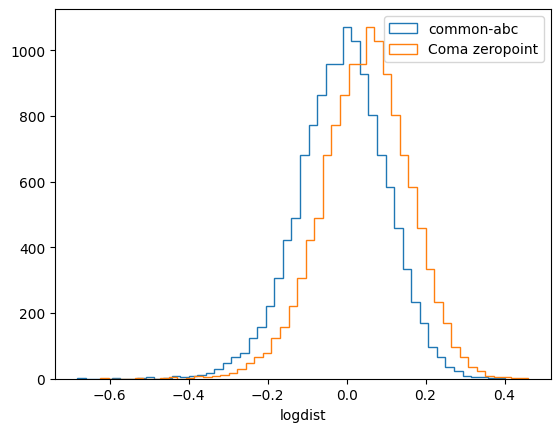

In [147]:
df = pd.DataFrame()
for survey in SURVEY_LIST:
    df_temp = pd.read_csv(f"./{survey.lower()}.csv")

    df = pd.concat([df, df_temp])

plt.hist(df['logdist_common_abc'], bins=50, label='common-abc', histtype='step')
plt.hist(df['logdist'], bins=50, label='Coma zeropoint', histtype='step')

plt.legend()
plt.xlabel('logdist')

plt.show()

# Velocity map

In [149]:
def combine_my_logdist():
    """Function to combine my logdist measurements and deduplicate 2MASS id by averaging
    """
    # Combine my data
    df = pd.DataFrame()
    for survey in SURVEY_LIST:
        df_temp = pd.read_csv(f"./{survey.lower()}.csv")[
            ['tmass', 'ra', 'dec', 'z_dist_est', f'logdist', f'logdist_err']
        ]

        df = pd.concat([df, df_temp])

    # Error-weighted average for repeat measurements
    df_dup = df.copy()
    df_dup = df_dup[df_dup.duplicated(subset='tmass', keep=False)]
    dup_tmass_id = df_dup['tmass'].unique().tolist()

    df_dup['w'] = df_dup['logdist_err'] ** (-2)
    df_dup['w_times_logdist'] = df_dup['w'] * df_dup['logdist']

    # Group by 2MASS ID and sum the weighted things
    df_grouped = df_dup.groupby(by='tmass', observed=False).agg(
        numerator=('w_times_logdist', 'sum'),
        denominator=('w', 'sum'),
        ra=('ra', 'mean'),
        dec=('dec', 'mean'),
        z_dist_est=('z_dist_est', 'mean'),
    )

    # Calculate error-weighted average of distance modulus and its error
    df_grouped['logdist_avg'] = df_grouped["numerator"] / df_grouped["denominator"]
    df_grouped['logdist_err_avg'] = 1 / np.sqrt(df_grouped["denominator"])
    df_grouped = df_grouped.reset_index()[['tmass', 'ra', 'dec', 'z_dist_est', 'logdist_avg', 'logdist_err_avg']].rename({
        'logdist_avg': 'logdist',
        'logdist_err_avg': 'logdist_err'
    }, axis=1)

    # Concatenate
    df = df[(~df['tmass'].isin(dup_tmass_id))]
    df = pd.concat([df, df_grouped])

    return df



# Constants
SIGMA_FIDUCIAL = 4.0
SCALE = 3
SGZ_grids = [-20., 0., 60., 80.]
MAX_DIST = 161.2
METHOD = 'common_abc'

# Get my (deduplicated) PV sample
df = combine_my_logdist()

# ---------------------------------- Calculate smoothing length for every galaxy ---------------------------------- #
# Get supergalactic coordinates vector for each galaxy
df = get_supergalactic_coords(df)
coords_data = np.array([df['SGX'], df['SGY'], df['SGZ']]).T

df['delta_j'] = df.apply(lambda x: get_smoothing_length(x.SGX, x.SGY, x.SGZ, coords_data, sigma_fid=SIGMA_FIDUCIAL, scale=SCALE), axis=1)
df['sigma_j'] = 2 * SIGMA_FIDUCIAL * np.sqrt(np.exp(np.log(df['delta_j']).sum() / len(df)) / df['delta_j'])


# ---------------------------------- Calculate smoothed logdist field ---------------------------------- #
# Unpack data
logdist = df['logdist'].to_numpy()
logdist_err = df['logdist_err'].to_numpy()
smoothing_length = df['sigma_j'].to_numpy()
coords_data = np.array([df['SGX'], df['SGY'], df['SGZ']]).T

# Create empty dataframe to store smoothed logdist field
df_smoothed = pd.DataFrame()
coords_grid = generate_grids(z_list=SGZ_grids, max_dist=MAX_DIST)
df_smoothed[['SGX', 'SGY', 'SGZ']] = coords_grid

# Determine N_j for each point i, calculate distance from every point to every galaxy
distances = np.sqrt(np.sum((coords_grid[:, None] - coords_data)**2, axis=2))
mask = distances <= SCALE * smoothing_length
N_j = np.sum(mask, axis=1)

# Calculate cosine of the angle between grid position and galaxy's position
grid_dist = np.sqrt(np.sum(coords_grid**2, axis=1))
gal_dist = np.sqrt(np.sum(coords_data**2, axis=1))
cos_theta = np.sum(coords_grid[:, None] * coords_data, axis=2) / (grid_dist[:, None] * gal_dist)

# Calculate the smoothed logdist for each grid and its estimated error
weight = 1
num_ = np.sum(mask * weight * logdist * cos_theta * np.exp(-0.5 * (distances / smoothing_length)**2) * (smoothing_length**(-3)), axis=1)
num_err_ = np.sum(mask * weight * logdist_err * cos_theta * np.exp(-0.5 * (distances / smoothing_length)**2) * (smoothing_length**(-3)), axis=1)
denom_ = np.sum(mask * weight * np.exp(-0.5 * (distances / smoothing_length)**2) * (smoothing_length**(-3)), axis=1)

# Save to the dataframe
df_smoothed['logdist_smoothed'] = num_ / denom_
df_smoothed['logdist_smoothed_err'] = num_err_ / denom_

# Remove NaNs
df_smoothed = df_smoothed[(~df_smoothed['logdist_smoothed'].isna()) & (~df_smoothed['logdist_smoothed_err'].isna())]

filepath = "./smoothed_coma.csv"
df_smoothed.to_csv(filepath, index=False)